In [114]:
import numpy as np
import pandas as pd
import sklearn
try:
    import xgboost 
except ImportError:
    print("Please install xgboost, refer to https://xgboost.readthedocs.io/en/latest/build.html")
try:
    import featexp
except ImportError:
    print("Please install featexp by pip.")
import matplotlib.pyplot as plt

# import subprocess
# print(subprocess.check_output(['conda','env', 'list']))

In [115]:
train_df = pd.read_csv('/Users/lichenle/Desktop/MyProject/CoursML/assignment2/all/train.csv')
test_df = pd.read_csv('/Users/lichenle/Desktop/MyProject/CoursML/assignment2/all/test.csv')

In [116]:
train_df.info()
test_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Encoding

In [117]:
train_df.loc[train_df['Sex']=='male', 'Sex']=1
train_df.loc[train_df['Sex']=='female', 'Sex']=0
test_df.loc[test_df['Sex']=='male', 'Sex']=1
test_df.loc[test_df['Sex']=='female', 'Sex']=0

train_df.loc[train_df['Embarked']=='S', 'Embarked']=0
train_df.loc[train_df['Embarked']=='C', 'Embarked']=1
train_df.loc[train_df['Embarked']=='Q', 'Embarked']=2

test_df.loc[test_df['Embarked']=='S', 'Embarked']=0
test_df.loc[test_df['Embarked']=='C', 'Embarked']=1
test_df.loc[test_df['Embarked']=='Q', 'Embarked']=2

# EDA

In [118]:
# Check for missing data & list them 
nas = pd.concat([train_df.isnull().sum(), test_df.isnull().sum()], axis=1, keys=['Train Dataset', 'Test Dataset']) 
print('Nan in the data sets')
print(nas[nas.sum(axis=1) > 0])

Nan in the data sets
          Train Dataset  Test Dataset
Age                 177          86.0
Cabin               687         327.0
Embarked              2           0.0
Fare                  0           1.0


/Users/lichenle/anaconda3/envs/foo/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


## Plots with featexp

                                           Plots for Pclass                                           


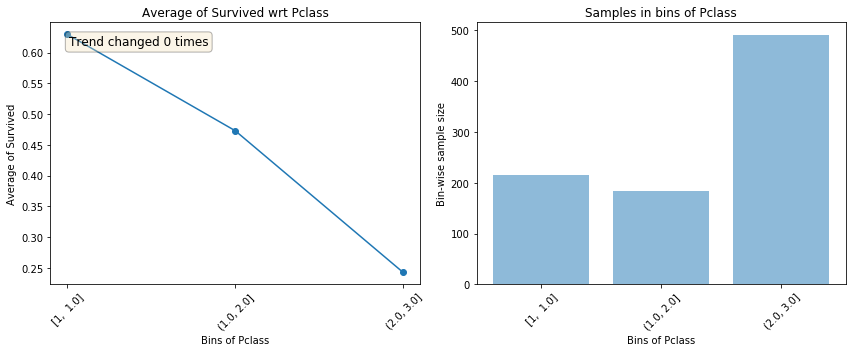

--------------------------------------------------------------------------------------------------------------


                                           Plots for SibSp                                            


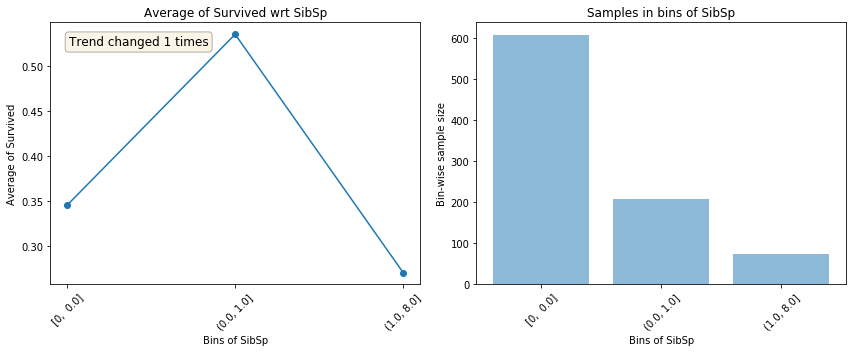

--------------------------------------------------------------------------------------------------------------


                                           Plots for Parch                                            


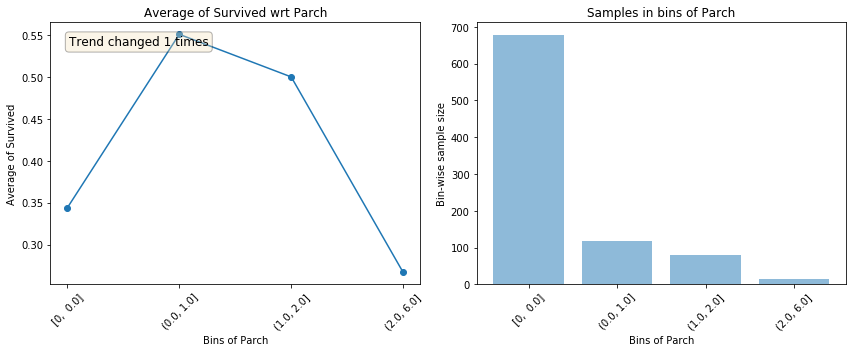

--------------------------------------------------------------------------------------------------------------


                                            Plots for Fare                                            


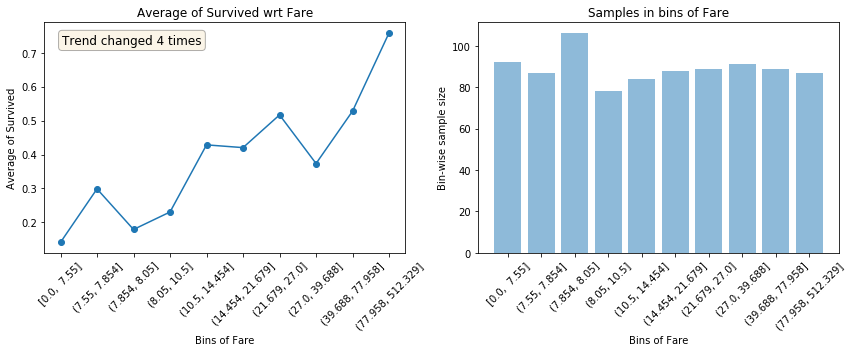

--------------------------------------------------------------------------------------------------------------


Embarked is categorical. Categorical features not supported yet.
                                            Plots for Age                                             


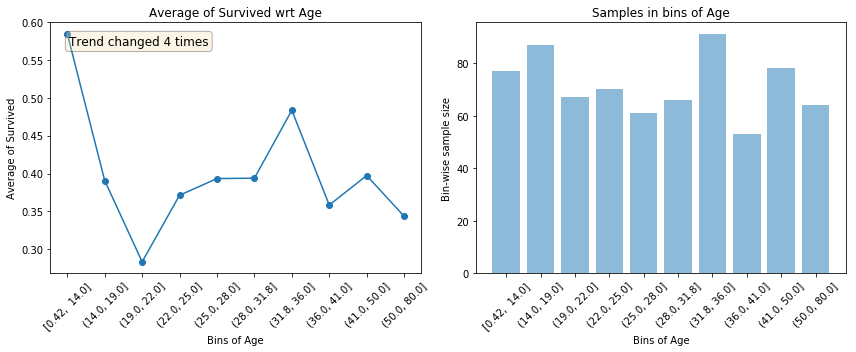

--------------------------------------------------------------------------------------------------------------




In [119]:
nums = ['Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked']
for feature in nums:
    featexp.get_univariate_plots(data=train_df.loc[train_df[feature].notnull()], target_col='Survived',
                          features_list=[feature], bins=10)
featexp.get_univariate_plots(data=train_df.loc[train_df['Age'].notnull()], target_col='Survived',
                      features_list=['Age'], bins=10)

# Data Cleaning

In [120]:
# Missing values

train_df['Age']=train_df['Age'].fillna(train_df.loc[train_df['Age'].notnull()]['Age'].mean())
train_df['Cabin'] = train_df['Cabin'].fillna(train_df['Cabin'].value_counts().index[0])
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].value_counts().index[0])

test_df['Age']=test_df['Age'].fillna(test_df.loc[train_df['Age'].notnull()]['Age'].mean())
test_df['Cabin'] = test_df['Cabin'].fillna(test_df['Cabin'].value_counts().index[0])
test_df['Embarked'] = test_df['Embarked'].fillna(test_df['Embarked'].value_counts().index[0])
test_df['Fare']=test_df['Fare'].fillna(test_df.loc[train_df['Fare'].notnull()]['Fare'].mean())

# Scale numbers
train_df['Fare'] = (train_df['Fare']-train_df['Fare'].min())/(train_df['Fare'].max()-train_df['Fare'].min())
test_df['Fare'] = (test_df['Fare']-test_df['Fare'].min())/(test_df['Fare'].max()-test_df['Fare'].min())
# Assure no missing values
nas = pd.concat([train_df.isnull().sum(), test_df.isnull().sum()], axis=1, keys=['Train Dataset', 'Test Dataset']) 
if nas[nas.sum(axis=1) > 0].empty:
    print("No missing values.")
else:        
    print('Nan in the data sets')
    print(nas[nas.sum(axis=1) > 0])

No missing values.


/Users/lichenle/anaconda3/envs/foo/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


# Tuning parameters

In [121]:
import warnings
warnings.filterwarnings(action ='ignore',category = DeprecationWarning)
from xgboost import XGBClassifier
from hyperopt import hp, fmin, tpe
from sklearn.metrics import accuracy_score
from functools import partial

def auto_turing(args):
    model = XGBClassifier(n_jobs = 4, n_estimators = args['n_estimators'],max_depth=6)
    model.fit(X,y)
    predictions = model.predict(X)
    accuracy = accuracy_score(y, predictions)
    print(accuracy)
    return -accuracy

algo = partial(tpe.suggest, n_startup_jobs=4)
space = {"n_estimators":hp.choice("n_estimators",range(40,200,20))}
print(fmin)
best = fmin(auto_turing, space, algo=algo,max_evals=30)
print(best)

<function fmin at 0x1a1b4188c8>
0.8888888888888888
0.8754208754208754
0.8754208754208754
0.8810325476992144
0.8888888888888888
0.8888888888888888
0.8585858585858586
0.8698092031425365
0.8843995510662177
0.8866442199775533
0.8877665544332211
0.8888888888888888
0.8888888888888888
0.8843995510662177
0.8877665544332211
0.8585858585858586
0.8698092031425365
0.8888888888888888
0.8888888888888888
0.8810325476992144
0.8866442199775533
0.8888888888888888
0.8888888888888888
0.8888888888888888
0.8810325476992144
0.8698092031425365
0.8754208754208754
0.8866442199775533
0.8585858585858586
0.8843995510662177
{'n_estimators': 7}


# Train

In [122]:
features = ['Pclass', 'SibSp', 'Parch', 'Fare', 'Sex']
X = train_df[features]
y = train_df['Survived']
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=6)
# clf = XGBClassifier(n_jobs = 4, n_estimators = best['n_estimators'],max_depth=6)
clf.fit(X, y)
Y_pred = clf.predict(test_df[features])

In [123]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('titanic.csv', index=False)
print('Exported')

Exported
